In [ ]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=0b863a85694ab48bcb948a4ff3c6e3f223ee5931f94acd14b2fae20352dfd50f
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord
     |████████████████████████████████| 11.8 MB 3.8 MB/s 
no display found. Using non-interactive Agg backend


## Universal Bank
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [ ]:
bank = pd.read_csv('UniversalBank.csv')
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank.drop(columns = ['ID','ZIP Code'],inplace=True)

In [ ]:
bank.columns = [c.replace(' ','_') for c in bank.columns]

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal_Loan       5000 non-null   int64  
 8   Securities_Account  5000 non-null   int64  
 9   CD_Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


In [ ]:
bank['Education'] = bank['Education'].astype('category')
new_cate = {1:'undergrad',
            2:'graduate',
            3:'professional'}
bank.Education.cat.rename_categories(new_cate,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [ ]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,undergrad,0,0,1,0,0,0
1,45,19,34,3,1.5,undergrad,0,0,1,0,0,0
2,39,15,11,1,1.0,undergrad,0,0,0,0,0,0
3,35,9,100,1,2.7,graduate,0,0,0,0,0,0
4,35,8,45,4,1.0,graduate,0,0,0,0,0,1


In [ ]:
bank = pd.get_dummies(bank,prefix_sep='_',drop_first=True) 

In [ ]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_graduate,Education_professional
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0


## Universal bank probabilities
Predict to get the probabilities

In [ ]:
X = bank.drop(columns='Personal_Loan')
y = bank['Personal_Loan']

train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4,random_state=1)

In [ ]:
from scipy.sparse.construct import rand
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X,train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
logit_reg.intercept_

array([-12.12625911])

In [ ]:
logit_reg.coef_

array([[-5.08786771e-02,  5.21590455e-02,  5.86883455e-02,
         6.09664454e-01,  2.40296329e-01,  1.00896463e-03,
        -1.03195380e+00,  3.65849972e+00, -6.81390010e-01,
        -9.57569248e-01,  4.20100938e+00,  4.35528428e+00]])

In [ ]:
print(pd.DataFrame({'coef':logit_reg.coef_[0]},index=X.columns))

                            coef
Age                    -0.050879
Experience              0.052159
Income                  0.058688
Family                  0.609664
CCAvg                   0.240296
Mortgage                0.001009
Securities_Account     -1.031954
CD_Account              3.658500
Online                 -0.681390
CreditCard             -0.957569
Education_graduate      4.201009
Education_professional  4.355284


In [ ]:
coeffdf = pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns)
coeffdf['odds'] = np.e**coeffdf['coef']
coeffdf

,coef,odds
Age,-0.050879,0.950394
Experience,0.052159,1.053543
Income,0.058688,1.060445
Family,0.609664,1.839814
CCAvg,0.240296,1.271626
Mortgage,0.001009,1.001009
Securities_Account,-1.031954,0.356310
CD_Account,3.658500,38.803084
Online,-0.681390,0.505913
CreditCard,-0.957569,0.383825


In [ ]:
logit_reg_prob = logit_reg.predict_proba(valid_X)

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)

In [ ]:
logit_result = pd.DataFrame({'actual':valid_y,
                             'p_0':[p[0] for p in logit_reg_prob],
                             'p_1':[p[1] for p in logit_reg_prob],
                             'predicted':logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
2764,0,0.975937,0.024063,0
4767,0,0.999938,0.000062,0
3814,0,0.999898,0.000102,0
3499,0,0.998407,0.001593,0
2735,0,0.956225,0.043775,0
...,...,...,...,...
4372,0,0.996092,0.003908,0
3401,0,0.999631,0.000369,0
1239,0,0.999785,0.000215,0
437,0,0.998503,0.001497,0


In [ ]:
classificationSummary(train_y,logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9607)

       Prediction
Actual    0    1
     0 2685   28
     1   90  197


In [ ]:
classificationSummary(valid_y,logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Universal Bank Gains Chart

In [ ]:
df = logit_result.sort_values(by='p_1',ascending=False)
df

,actual,p_0,p_1,predicted
3373,1,0.000575,0.999425,1
2217,1,0.000866,0.999134,1
787,1,0.001103,0.998897,1
47,1,0.002364,0.997636,1
3006,1,0.002462,0.997538,1
...,...,...,...,...
1100,0,0.999997,0.000003,0
4922,0,0.999997,0.000003,0
1720,0,0.999997,0.000003,0
3125,0,0.999998,0.000002,0


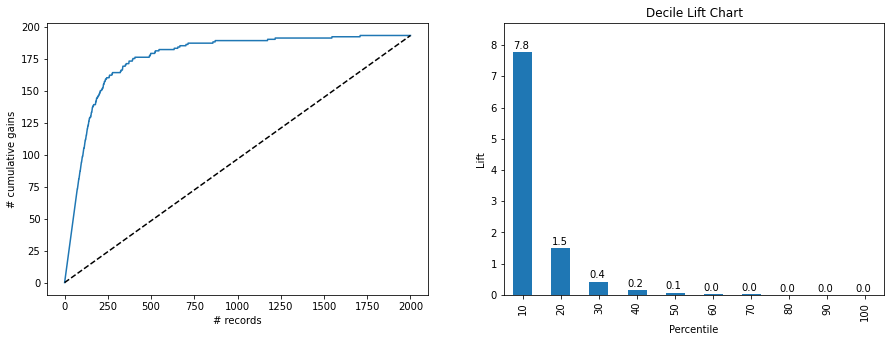

In [ ]:
fig, axes = plt.subplots(1,2, figsize=[15,5])
gainsChart(df.actual,ax=axes[0])
liftChart(df['p_1'],ax=axes[1])

## Flight Delays

In [ ]:
delays = pd.read_csv('FlightDelays.csv')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
delays.DAY_WEEK = delays.DAY_WEEK.astype('category')
delays.CRS_DEP_TIME = [round(t/100) for t in delays.CRS_DEP_TIME]
delays.CRS_DEP_TIME = delays.CRS_DEP_TIME.astype('category')
delays.DAY_WEEK = delays.DAY_WEEK.astype('category')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
delays['isdelayed'] = [1 if a == 'delayed' else 0 for a in delays['Flight Status']]

In [ ]:
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isdelayed
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0


In [ ]:
predictors = ['CRS_DEP_TIME','DAY_WEEK','ORIGIN','DEST','CARRIER']
outcome = 'isdelayed'

X = pd.get_dummies(delays[predictors],drop_first=True)
y = delays[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4,random_state=1)

split /
declare model /
fit model /
predictions /
probabilities /
data frame of predictions /
confusion matrix /
gains chart

In [ ]:
log_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
log_reg.fit(train_X,train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
print('intercept',log_reg.intercept_)

intercept [-1.11680634]


In [ ]:
print(pd.DataFrame({'coef':log_reg.coef_[0],
                    'odds':np.e**log_reg.coef_[0]},
                   index=X.columns))

                     coef      odds
CRS_DEP_TIME_7   0.619965  1.858863
CRS_DEP_TIME_8   0.384634  1.469077
CRS_DEP_TIME_9  -0.168302  0.845099
CRS_DEP_TIME_10  0.439087  1.551290
CRS_DEP_TIME_11  0.055248  1.056803
CRS_DEP_TIME_12  0.485043  1.624245
CRS_DEP_TIME_13  0.183348  1.201233
CRS_DEP_TIME_14  0.329139  1.389771
CRS_DEP_TIME_15  1.319538  3.741692
CRS_DEP_TIME_16  0.667728  1.949802
CRS_DEP_TIME_17  1.121528  3.069540
CRS_DEP_TIME_18  0.277080  1.319272
CRS_DEP_TIME_19  1.680137  5.366292
CRS_DEP_TIME_20  1.009472  2.744153
CRS_DEP_TIME_21  1.133060  3.105144
DAY_WEEK_2      -0.480597  0.618414
DAY_WEEK_3      -0.791871  0.452997
DAY_WEEK_4      -0.890501  0.410450
DAY_WEEK_5      -0.385297  0.680249
DAY_WEEK_6      -1.214981  0.296716
DAY_WEEK_7      -0.188653  0.828074
ORIGIN_DCA      -0.100889  0.904033
ORIGIN_IAD      -0.174114  0.840201
DEST_JFK        -0.448727  0.638440
DEST_LGA        -0.464066  0.628722
CARRIER_DH       0.286247  1.331422
CARRIER_DL      -0.708458  0

In [ ]:
log_reg_prob = log_reg.predict_proba(valid_X)
log_reg_pred = log_reg.predict(valid_X)

In [ ]:
log_result = pd.DataFrame({'actual':valid_y,
                           'predicted':log_reg_pred,
                            'p_0_ontime':[p[0] for p in log_reg_prob],
                            'p_1_delayed':[p[1] for p in log_reg_prob]
                             })
log_result

,actual,predicted,p_0_ontime,p_1_delayed
1276,0,0,0.686901,0.313099
1446,0,0,0.960155,0.039845
335,0,0,0.805467,0.194533
1458,0,0,0.948094,0.051906
2038,0,0,0.966451,0.033549
...,...,...,...,...
460,0,0,0.812663,0.187337
2063,0,0,0.903135,0.096865
159,0,0,0.824281,0.175719
2027,1,0,0.953369,0.046631


In [ ]:
classes = ['ontime','delayed']
classificationSummary(log_result.actual,log_result.predicted, class_names=classes)

Confusion Matrix (Accuracy 0.8093)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     159       8


In [ ]:
df = log_result.sort_values(by='p_1_delayed',ascending=False)
df

,actual,predicted,p_0_ontime,p_1_delayed
264,1,1,0.326386,0.673614
724,0,1,0.369136,0.630864
1328,0,1,0.386407,0.613593
1850,1,1,0.386407,0.613593
825,0,1,0.386407,0.613593
...,...,...,...,...
1561,0,0,0.974362,0.025638
434,0,0,0.976046,0.023954
1051,1,0,0.978247,0.021753
140,0,0,0.980294,0.019706


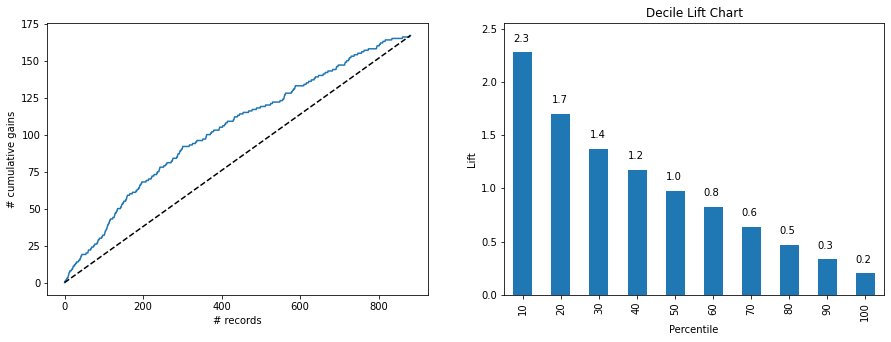

In [ ]:
fig, axes = plt.subplots(1,2, figsize=[15,5])
gainsChart(df.actual,ax=axes[0])
liftChart(df['p_1_delayed'],ax=axes[1])

we can take action on 200 flights that are most likely to be delayed. (It means 70 targets covered in the top 200 data based on the model).

https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14


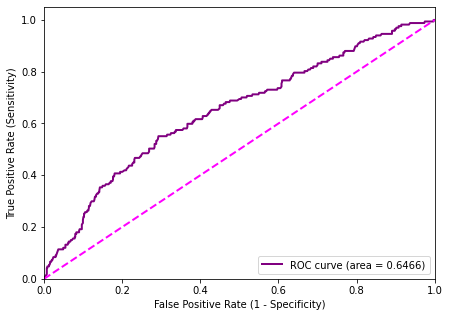

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(df['actual'], df['p_1_delayed']) 
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[7, 5]) 
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='magenta', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)') 
plt.legend(loc="lower right")

## Flight Delays Summary

## Nominal logistic regression

In [ ]:
data = pd.read_csv('accidentsFull.csv')
data.head()

,HOUR_I_R,ALCHL_I,ALIGN_I,STRATUM_R,WRK_ZONE,WKDY_I_R,INT_HWY,LGTCON_I_R,MANCOL_I_R,PED_ACC_R,RELJCT_I_R,REL_RWY_R,PROFIL_I_R,SPD_LIM,SUR_COND,TRAF_CON_R,TRAF_WAY,VEH_INVL,WEATHER_R,INJURY_CRASH,NO_INJ_I,PRPTYDMG_CRASH,FATALITIES,MAX_SEV_IR
0,0,2,2,1,0,1,0,3,0,0,1,0,1,40,4,0,3,1,1,1,1,0,0,1
1,1,2,1,0,0,1,1,3,2,0,1,1,1,70,4,0,3,2,2,0,0,1,0,0
2,1,2,1,0,0,1,0,3,2,0,1,1,1,35,4,1,2,2,2,0,0,1,0,0
3,1,2,1,1,0,0,0,3,2,0,1,1,1,35,4,1,2,2,1,0,0,1,0,0
4,1,1,1,0,0,1,0,3,2,0,0,1,1,25,4,0,2,3,1,0,0,1,0,0


In [ ]:
data.ALCHL_I=data.ALCHL_I.astype('category')
data.WEATHER_R=data.WEATHER_R.astype('category')
data.WRK_ZONE=data.WRK_ZONE.astype('category')
data.MAX_SEV_IR=data.MAX_SEV_IR.astype('category')

In [ ]:
predictors = ['ALCHL_I','WEATHER_R','WRK_ZONE','SPD_LIM','VEH_INVL']
outcome = 'MAX_SEV_IR'

In [ ]:
X = pd.get_dummies(data[predictors],drop_first=True)
y = data[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4,random_state=1)

In [ ]:
logit = LogisticRegression(C=1,multi_class='multinomial',solver='lbfgs',max_iter=1000,random_state=1)
# using c=1, because we are not so confident this data represents the real world
logit.fit(train_X,train_y)

LogisticRegression(C=1, max_iter=1000, multi_class='multinomial',
                   random_state=1)

In [ ]:
log_reg_prob = logit.predict_proba(valid_X)
log_reg_pred = logit.predict(valid_X)

In [ ]:
log_result = pd.DataFrame({'actual':valid_y,
                           'predicted':log_reg_pred,
                           'p_0':[p[0] for p in log_reg_prob],
                           'p_1':[p[1] for p in log_reg_prob],
                           'p_2':[p[2] for p in log_reg_prob],
                             })
log_result

,actual,predicted,p_0,p_1,p_2
24895,1,1,0.480851,0.503687,0.015462
5306,0,1,0.482317,0.506584,0.011099
21954,0,1,0.483733,0.512187,0.004080
37948,1,1,0.483614,0.510686,0.005700
39072,0,1,0.483614,0.510686,0.005700
...,...,...,...,...,...
20008,0,1,0.483183,0.508860,0.007957
40905,0,0,0.525620,0.466603,0.007777
40952,1,0,0.525206,0.465609,0.009186
18454,0,1,0.483183,0.508860,0.007957


In [ ]:
logit.intercept_

array([ 1.06227291,  1.18807795, -2.25035086])

In [ ]:
pd.DataFrame({'coef':logit.coef_[0],'odds':np.e**logit.coef_[0]},index=X.columns)

,coef,odds
SPD_LIM,-0.011062,0.988999
VEH_INVL,0.128577,1.137209
ALCHL_I_2,0.529879,1.698727
WEATHER_R_2,0.432334,1.540849
WRK_ZONE_1,-0.040307,0.960494


In [ ]:
log_reg_pred

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
log_reg_prob

array([[0.48085098, 0.50368732, 0.0154617 ],
       [0.48231716, 0.50658384, 0.011099  ],
       [0.48373291, 0.51218699, 0.0040801 ],
       ...,
       [0.52520558, 0.46560876, 0.00918565],
       [0.48318281, 0.50885986, 0.00795733],
       [0.41546707, 0.55671349, 0.02781943]])

In [ ]:
probs = pd.DataFrame({'p_0':[p[0] for p in log_reg_prob],
                      'p_1':[p[1] for p in log_reg_prob],
                      'p_2':[p[2] for p in log_reg_prob]})
probs

,p_0,p_1,p_2
0,0.480851,0.503687,0.015462
1,0.482317,0.506584,0.011099
2,0.483733,0.512187,0.004080
3,0.483614,0.510686,0.005700
4,0.483614,0.510686,0.005700
...,...,...,...
16869,0.483183,0.508860,0.007957
16870,0.525620,0.466603,0.007777
16871,0.525206,0.465609,0.009186
16872,0.483183,0.508860,0.007957


In [ ]:
pred = pd.DataFrame({'predicted': log_reg_pred})

In [ ]:
results = pd.concat([valid_y.reset_index(drop = True),pred,probs],axis=1)
results.head()

,MAX_SEV_IR,predicted,p_0,p_1,p_2
0,1,1,0.480851,0.503687,0.015462
1,0,1,0.482317,0.506584,0.011099
2,0,1,0.483733,0.512187,0.004080
3,1,1,0.483614,0.510686,0.005700
4,0,1,0.483614,0.510686,0.005700


In [ ]:
# ignore
preds = [(np.max(arr), np.argmax(arr)) for arr in logit.predict_proba(valid_X)]
pd.concat([valid_y.reset_index(), pd.Series(preds)], axis = 1)

,index,MAX_SEV_IR,0
0,24895,1,"(0.5036873223099868, 1)"
1,5306,0,"(0.5065838359163458, 1)"
2,21954,0,"(0.5121869915569373, 1)"
3,37948,1,"(0.5106859451287437, 1)"
4,39072,0,"(0.5106859451287437, 1)"
...,...,...,...
16869,20008,0,"(0.5088598567405177, 1)"
16870,40905,0,"(0.5256199433929312, 0)"
16871,40952,1,"(0.5252055803913939, 0)"
16872,18454,0,"(0.5088598567405177, 1)"


In [ ]:
classificationSummary(valid_y,pred)

Confusion Matrix (Accuracy 0.4978)

       Prediction
Actual    0    1    2
     0 2804 5525    0
     1 2758 5596    0
     2   77  114    0
